# Clasificador de Imágenes: aprendizaje supervisado y no supervisado

## Importando Paquetes

In [2]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
import csv
import os
import random
import math
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Definiendo constantes, paths, diccionarios y métodos útiles

In [3]:
CLASSNAMES = {
    0 : 'buildings',
    1 : 'barren-land',
    2 : 'water',
    3 : 'grassland', 
    4 : 'roads',
    5 : 'trees', 
}

n_classes = 6
img_shape = 28
n_channels = 3

Estos métodos son para contar filas, contar archivos en determinados directorios, revolver archivos para darle aleatoriedad al input, y una serie de wrappers que facilitan la implementación del código como su lectura

In [4]:
def count_csv_rows(csvfile):
    total_rows = 0
    with open(csvfile, 'rt') as file:
        row_count = sum(1 for row in csv.reader(file))
        total_rows = row_count
    file.close()    
    return total_rows

def count_files(dir_path):
    total_files = 0
    for file in os.listdir(dir_path):
        #avoid invisible files to be counted
        if not file.startswith('.'):
            total_files += 1

    return total_files

def shuffle_files(file1, file2):
    filenames = list(zip(file1, file2))
    random.shuffle(filenames)
    file1, file2 = zip(*filenames)
    return file1, file2

def ConvLayer(input_layer,n_filters,f_shape, name):
    return tf.layers.conv2d(inputs=input_layer, filters=n_filters, kernel_size=f_shape,
        strides=1, padding="same", name=name, activation=tf.nn.relu)

def Pooling(input_layer,name):
    return tf.layers.max_pooling2d(inputs=input_layer, pool_size=2,
        strides=2, padding="same", name=name)

def OutputLayer(dense_layer):
    return tf.layers.dense(inputs=dense_layer, units=n_classes)

## Cargando nuestros datos

In [5]:
# paths for training images and labels, testing images and labels
train_images_dir = '/Users/mac/code/custom-cnn/train_images/'
train_labels_dir = '/Users/mac/code/custom-cnn/train_labels/'
test_images_dir  = '/Users/mac/code/custom-cnn/test_images/'
test_labels_dir = '/Users/mac/code/custom-cnn/test_labels/'

In [6]:
# counting files in those directories (easier to count respective labels)
n_training_labels = count_files(train_labels_dir)
n_testing_labels = count_files(test_labels_dir)
n_training_files = n_training_labels
n_testing_files = n_testing_labels
print('n training files: ',n_training_files)
print('n training labels: ',n_training_labels)
print('n testing files: ',n_testing_files)
print('n testig labels: ',n_testing_labels)

n training files:  10
n training labels:  10
n testing files:  3
n testig labels:  3


Hemos definidos las constantes extract1 y extract2, que disminuyen la cantidad de archivos de images y labels, respectivamente, para hacer una menor cantidad de computaciones (a costa de precisión)

In [7]:
extract1 = 0 # maximo 9
extract2 = 0 # maximo 2

In [8]:
# Lists of all img files and labels
training_filenames = [(train_images_dir+'X_train_%d.csv' % i) for i in range(1,n_training_files-extract1 +1)]
training_labels = [(train_labels_dir+'train_labels_%d.csv' % i) for i in range(1,n_training_labels-extract1 +1)]

testing_filenames = [(test_images_dir+'X_test_%d.csv' % i) for i in range(1,n_testing_files-extract2 +1)]
testing_labels = [(test_labels_dir+'test_labels_%d.csv' % i) for i in range(1,n_testing_labels-extract2 +1)]

print('number of training files we are using:', len(training_filenames))
print('number of training labels we are using:', len(training_labels))
print('number of testing files we are using:', len(testing_filenames))
print('number of testing labels we are using:', len(testing_labels))

number of training files we are using: 10
number of training labels we are using: 10
number of testing files we are using: 3
number of testing labels we are using: 3


In [9]:
# Shuffling files
training_filenames, training_labels = shuffle_files(training_filenames, training_labels)
testing_filenames, testing_labels = shuffle_files(testing_filenames, testing_labels)

In [10]:
# Just one file with its respective label for a quick review 
train_file_path = train_images_dir+'X_train_7.csv'
train_label_path = train_labels_dir+'train_labels_7.csv'

# and a testing case
test_file_path = test_images_dir+'X_test_3.csv'
test_label_path =test_labels_dir+'test_labels_3.csv'

# Counting examples per file 
n_rows_train_file = count_csv_rows(train_label_path)
n_rows_test_file = count_csv_rows(test_label_path)

print('number of rows in training file:', n_rows_train_file)
print('number of rows in testing file:', n_rows_test_file)

number of rows in training file: 32400
number of rows in testing file: 16200


# Métodos de Preprocessing

In [11]:
# este metodo tiene como proposito facilitar la visualizacion de las siguientes imagenes
def process_data_for_visualization(train_path, label_path, img_shape, n_rows):
    # Pre-processing data. Returns numpy arrays
    img_df = pd.read_csv(train_path, nrows=n_rows, header=None) 
    labels_df = pd.read_csv(label_path, nrows=n_rows, header=None)
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]
    np_x = np_x/255

    y = labels_df.values.astype(np.uint8)
    y = np.argmax(y, axis=1)

    return np_x, y

# est emetodo tiene como proposito el procesamiento de los datos para el modelo
def process_data(img_df, labels_df, img_shape):
    # Pre-processing data. Returns numpy arrays
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]
    np_x = np_x/255

    np_y = labels_df.values.astype(np.uint8)

    return np_x, np_y

Verificamos las dimensiones de nuestros datos una vez procesados

In [150]:
test_images, test_labels = process_data_for_visualization(test_file_path, test_label_path, img_shape, 50)

In [13]:
print(test_images.shape, test_labels.shape)

(50, 28, 28, 3) (50,)


# Visualización previa de nuestro dataset

 Para formarnos una idea de las imágenes con las que estamos trabajando, ploteamos  muestras, y guardamos un ejemplo de cada una de las clases, que nos servirán para testear el comportamiento de nuestra red

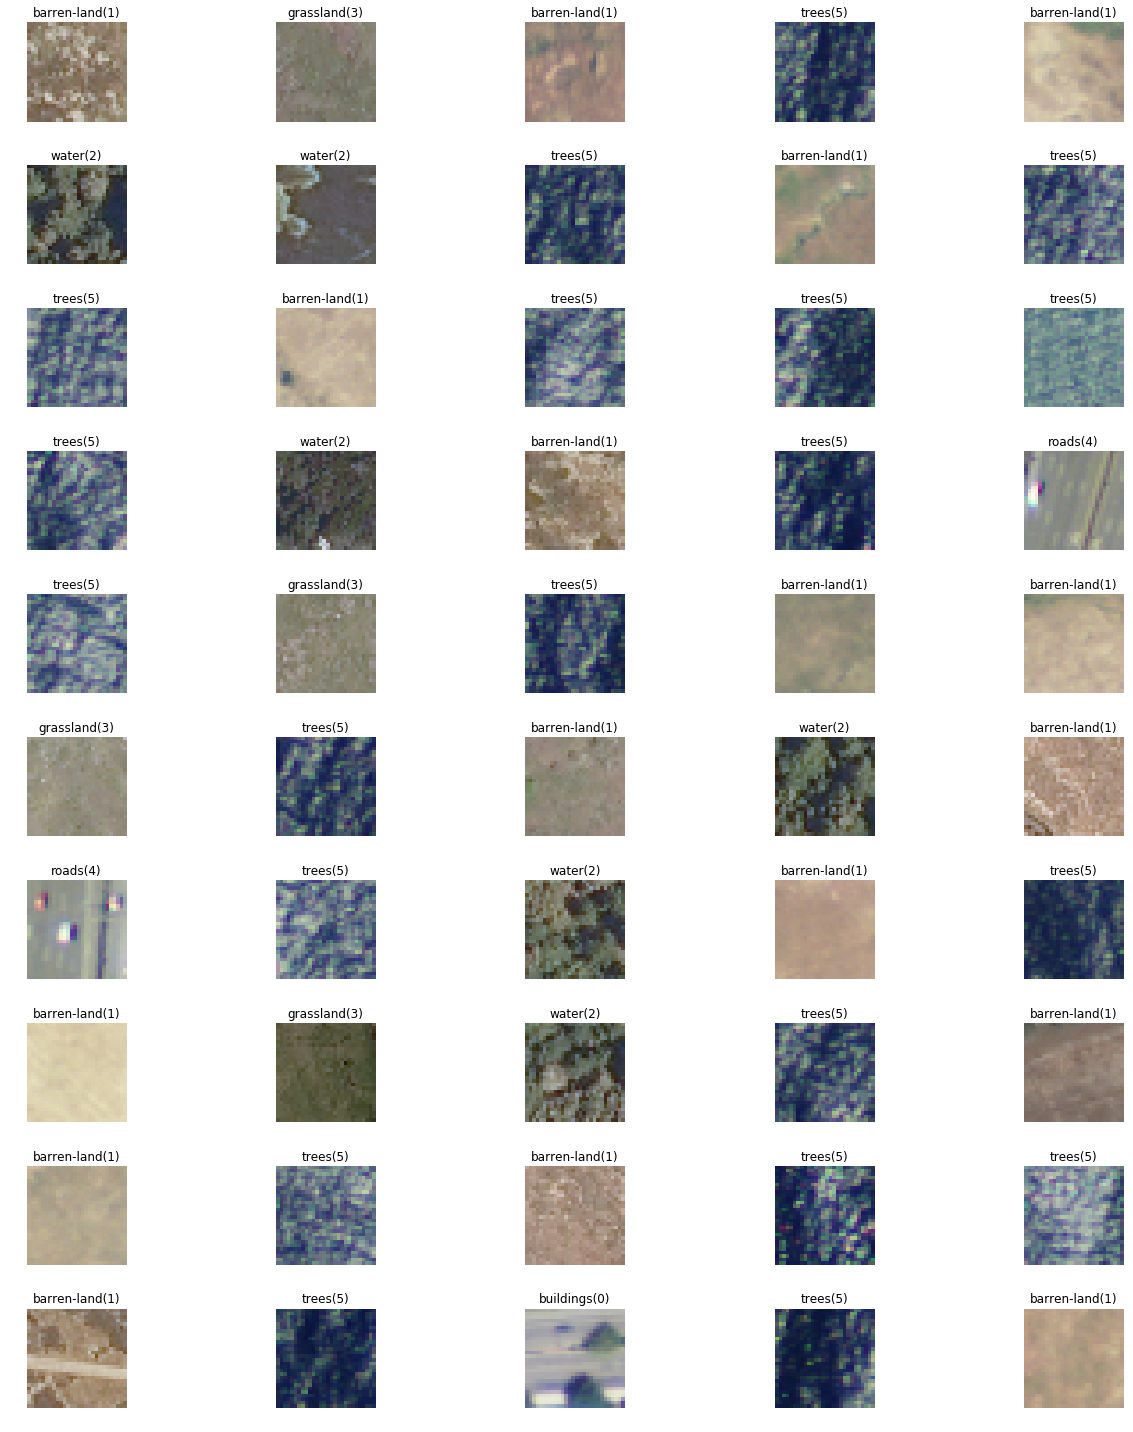

In [18]:
fig, m_axs = plt.subplots(10, test_images.shape[0]//10, figsize = (20, 20))
# Vector que guarda una imagen de cada clase
img_vector = []
label_vector = []
for (x, y, c_ax) in zip(test_images, test_labels, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title(((CLASSNAMES[y])+"({})").format(y))
    plt.tight_layout()
    if (y not in label_vector):
        img_vector.append(x)
        label_vector.append(y)    

## Visualización del vector que contiene una imagen de cada clase

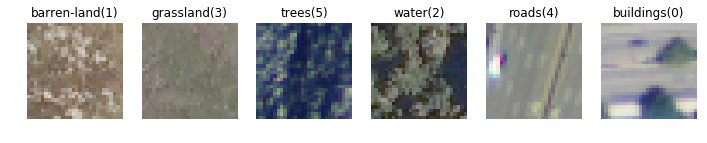

In [19]:
fig, m_axs = plt.subplots(1, 6, figsize = (12, 12))
for (x, y, c_ax) in zip(img_vector, label_vector, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title(((CLASSNAMES[y])+"({})").format(y))

# Defimos nuestro modelo

In [20]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    with tf.variable_scope("first_CNN"):
        # Hyperparameters and constants regarding each dataset
        epochs = 1
        learning_rate = 0.001 
        batch_size = n_rows_train_file//100
        test_batch_size = n_rows_test_file//100
        print('batch size:', batch_size)

        # Defining data placeholders
        x = tf.placeholder(tf.float32, [None, 28, 28, 3])
        y = tf.placeholder(tf.float32, [None, n_classes])
        drop_prob = tf.placeholder("float")

        # Conv Net and Optimization
        n_filters = 32
        f_shape = 3

        # input -> first layer
        conv_layer1 = ConvLayer(x, n_filters, f_shape, 'conv_layer1')
        conv_layer2 = ConvLayer(conv_layer1, n_filters, f_shape, 'conv_layer2')
        pool_layer1 = Pooling(conv_layer1, 'pool_layer1')

        conv_layer3 = ConvLayer(pool_layer1, 2*n_filters, f_shape, 'conv_layer3')
        conv_layer4 = ConvLayer(conv_layer3, 2*n_filters, f_shape, 'conv_layer4')
        pool_layer2 = Pooling(conv_layer4, 'pool_layer2')

        flat_layer = tf.layers.flatten(inputs=pool_layer1)

        dense_layer1 = tf.layers.dense(inputs=flat_layer, units=1024, activation= tf.nn.relu)

        dropout = tf.layers.dropout(inputs= dense_layer1, rate=drop_prob)

        prediction = OutputLayer(dropout)


        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        saver = tf.train.Saver()




batch size: 324


# Training

In [21]:
#sess= tf.Session()
#sess.run(tf.global_variables_initializer())

In [22]:
train_loss = []
train_accuracy = []
print("Starting Training...")
with tf.Session(graph=g) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(epochs):
        for j in range(len(training_filenames)):
            print("Training File " + str(j) + ": ")
            cnt = 1
            for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
                batch_x, batch_y = process_data(image_chunk, label_chunk, img_shape)

                # Run optimization op (backprop).
                opt = sess.run(optimizer, feed_dict={x: batch_x,y: batch_y, drop_prob: 0.5})
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, drop_prob: 0.5})

                if(cnt%10==0):
                    train_loss.append(loss)
                    train_accuracy.append(acc)
                    print("Batch " + "{:2d}".format(cnt)  + ": Loss= " + \
                                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                                  "{:.4f}".format(acc))
                    print("Processing next 10 training Batches...")
                cnt+=1

        print("Epoch " + str(i) + ": Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.4f}".format(acc))
        print("Processing next epoch...")
    saver.save(sess, "./first_CNN_supervised_learning.ckpt")
    print("Training has finished.")
    

Starting Training...
Training File 0: 
Batch 10: Loss= 0.6323, Training Accuracy= 0.7809
Processing next 10 training Batches...
Batch 20: Loss= 0.3940, Training Accuracy= 0.8519
Processing next 10 training Batches...
Batch 30: Loss= 0.2573, Training Accuracy= 0.9167
Processing next 10 training Batches...
Batch 40: Loss= 0.2388, Training Accuracy= 0.9105
Processing next 10 training Batches...
Batch 50: Loss= 0.2376, Training Accuracy= 0.8920
Processing next 10 training Batches...
Batch 60: Loss= 0.2503, Training Accuracy= 0.8889
Processing next 10 training Batches...
Batch 70: Loss= 0.1647, Training Accuracy= 0.9506
Processing next 10 training Batches...
Batch 80: Loss= 0.1359, Training Accuracy= 0.9599
Processing next 10 training Batches...
Batch 90: Loss= 0.1052, Training Accuracy= 0.9660
Processing next 10 training Batches...
Batch 100: Loss= 0.1557, Training Accuracy= 0.9198
Processing next 10 training Batches...
Training File 1: 
Batch 10: Loss= 0.1180, Training Accuracy= 0.9599
Pr

Batch 10: Loss= 0.0800, Training Accuracy= 0.9784
Processing next 10 training Batches...
Batch 20: Loss= 0.0537, Training Accuracy= 0.9784
Processing next 10 training Batches...
Batch 30: Loss= 0.1320, Training Accuracy= 0.9599
Processing next 10 training Batches...
Batch 40: Loss= 0.1015, Training Accuracy= 0.9568
Processing next 10 training Batches...
Batch 50: Loss= 0.0563, Training Accuracy= 0.9784
Processing next 10 training Batches...
Batch 60: Loss= 0.0578, Training Accuracy= 0.9815
Processing next 10 training Batches...
Batch 70: Loss= 0.0864, Training Accuracy= 0.9722
Processing next 10 training Batches...
Batch 80: Loss= 0.0524, Training Accuracy= 0.9877
Processing next 10 training Batches...
Batch 90: Loss= 0.0998, Training Accuracy= 0.9630
Processing next 10 training Batches...
Batch 100: Loss= 0.0866, Training Accuracy= 0.9691
Processing next 10 training Batches...
Epoch 0: Loss= 0.0866, Training Accuracy= 0.9691
Processing next epoch...
Training has finished.


## Testing

In [23]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt" )
    print("Starting Testing...")
    total_test_acc = 0
    total_test_batches = 1
    for k in range(len(testing_filenames)):
        print('Testing File {} '.format(k+1))
        cnt = 1   
        for image_chunk,label_chunk in zip(pd.read_csv(test_file_path, header=None, chunksize= test_batch_size), pd.read_csv(test_label_path,header=None,chunksize=test_batch_size)):
            test_batch_x, test_batch_y = process_data(image_chunk, label_chunk, img_shape)

            test_acc, test_loss = sess.run([accuracy,cost], feed_dict={x: test_batch_x, y : test_batch_y, drop_prob: 1.0})
            total_test_acc += test_acc
            cnt+=1
            total_test_batches += 1

    avg_test_acc = total_test_acc/total_test_batches
    print("Testing Accuracy:","{:.4f}".format(avg_test_acc))

Starting Testing...
Testing File 1 
Testing File 2 
Testing File 3 
Testing Accuracy: 0.9723


## Visualización del cambio de la función de costos y la precisión 

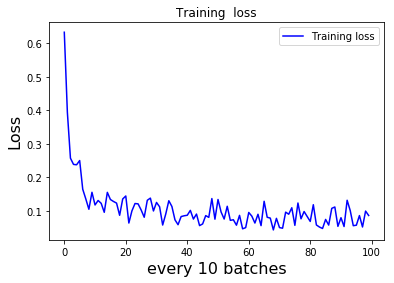

In [24]:
fig1 = plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.title('Training  loss')
plt.xlabel('every 10 batches',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
fig1.savefig('training-loss.png')
plt.show()

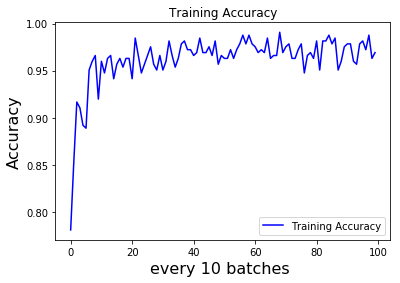

In [25]:
fig2 = plt.figure()
plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('every 10 batches ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
fig2.savefig('training-acc.png')
plt.show()

In [26]:
# esta funcion la tome de aqui: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)
    print('w shape: ',w.shape)
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    print('num filters:', num_filters)
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    print('num grids:', num_grids)
    n_columns = 4
    n_rows = math.ceil(num_filters / n_columns) + 1
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(n_rows -1, n_columns, figsize=(20,20))
    

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='gray')
            #ax.set_title('Filter ' + str(i+1))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Visualización de filtros en las primeras Convolutional Layers

Primera capa

w shape:  (3, 3, 3, 32)
num filters: 32
num grids: 6


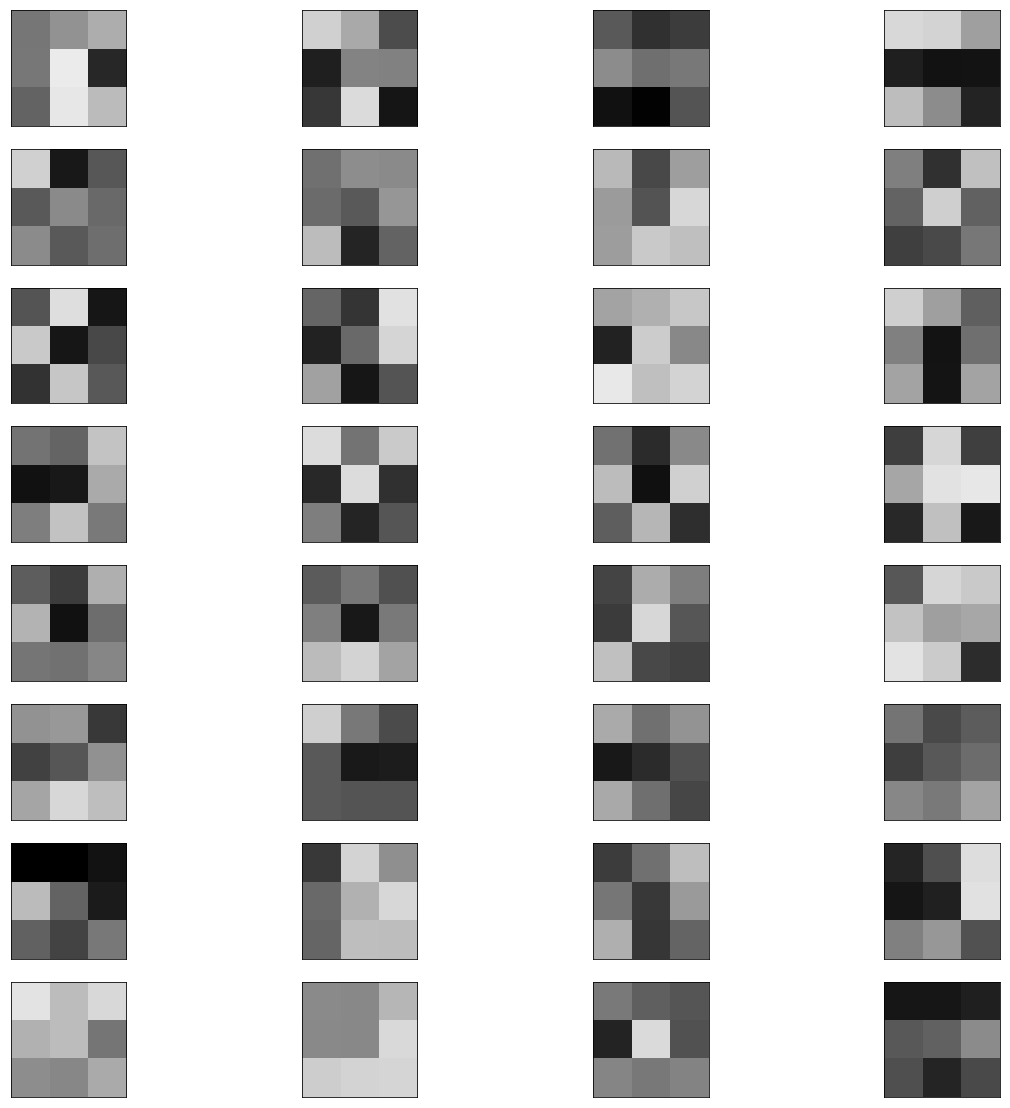

In [27]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt" )    
    weights_conv_layer_1= tf.get_collection(tf.GraphKeys.VARIABLES, 'first_CNN/conv_layer1/kernel')[0]
    plot_conv_weights(weights=weights_conv_layer_1)

Segunda capa. Esta capa a diferencia de la primera tiene 32 input channels, que hacen referencia a los 32 feature maps que se generaron a partir de la primera capa 

w shape:  (3, 3, 32, 32)
num filters: 32
num grids: 6


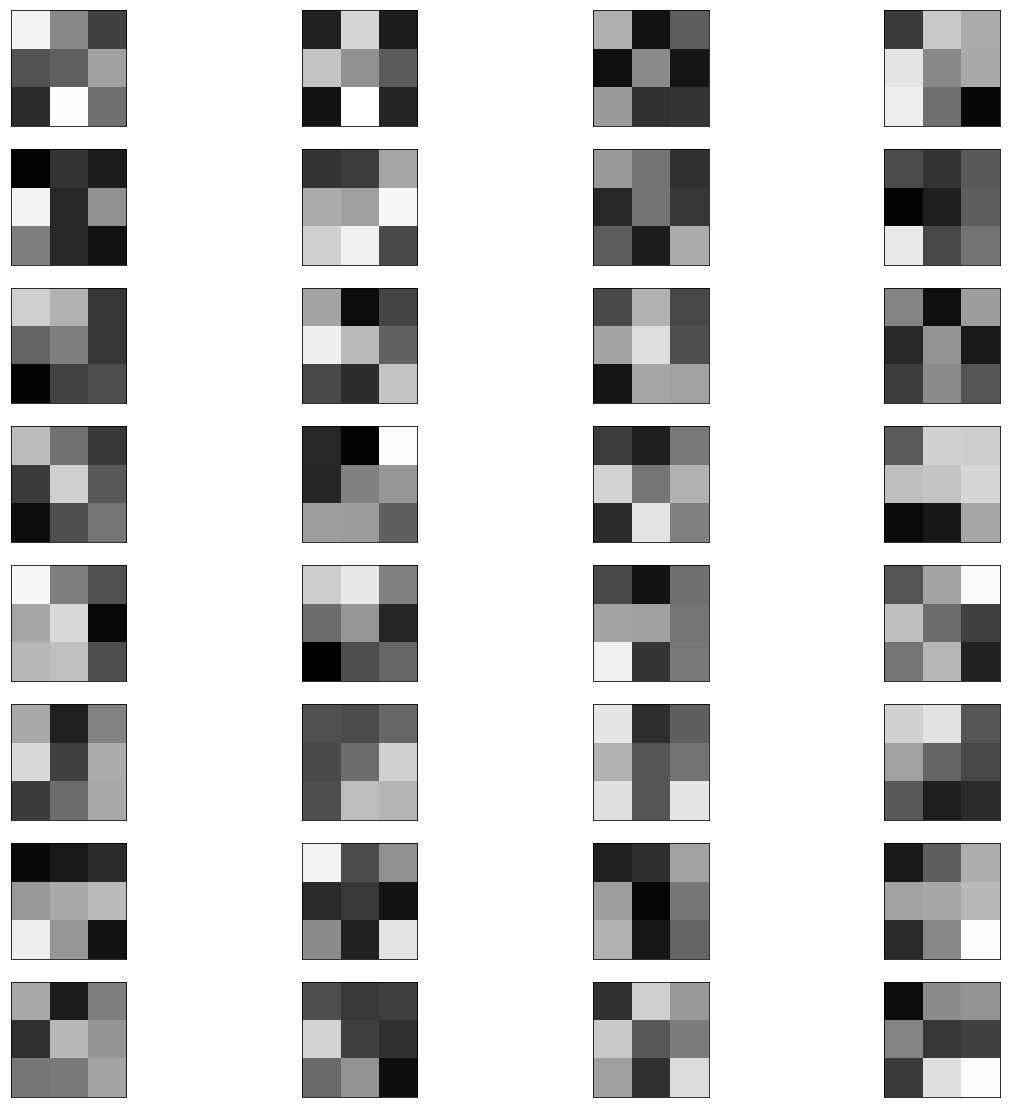

In [28]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt" )    
    weights_conv_layer_2= tf.get_collection(tf.GraphKeys.VARIABLES, 'first_CNN/conv_layer2/kernel')[0]
    plot_conv_weights(weights=weights_conv_layer_2, input_channel = 31)

## Visualización de Activation maps

Para alimentar la red, las imagenes deben estar en un formato específico. definimos entonces una función, feed_format, que utilizaremos después para alimentar cierto layer de la red con el vector de imagenes img_vector y poder visualizar los activation maps en esa capa.


In [29]:
def feed_format(images):
    new_images = np.array(images).reshape(-1,img_shape, img_shape, 3)
    return new_images

Verifiquemos su uso, y el formato que nos entrega

In [30]:
new_img_vector = feed_format(img_vector)
print(new_img_vector.shape)
print(new_img_vector[5:6].shape)

(6, 28, 28, 3)
(1, 28, 28, 3)


definimos la funcion visActivationMaps, que dado un vector de imágenes y un layer de la red específico, podemos visualizar el mapa de activaciones de los filtros que convolucionan sobre esas imágenes

In [31]:
def visActivationMaps(image_vector, labels, layer):
    num_filters = 0
    for k in range(len(image_vector)):
        y = labels[k]
        # ploteamos la imagen que pasa por el layer (i.e una imagen de cada categoria)
        main = plt.figure(figsize=(2,2))
        plt.title('class ' + CLASSNAMES[(y)])
        plt.axis('off')
        #plt.savefig(label_dict[(y)])
        plt.imshow(image_vector[k], cmap='gray')
        new_images = feed_format(image_vector)
        
        x_input = new_images[k:k+1]
        units = sess.run(layer,feed_dict={x: x_input, drop_prob:1.0})
        num_filters = units.shape[3]

        n_columns = 4
        n_rows = math.ceil(num_filters / n_columns) + 1

        fig, axes = plt.subplots(n_rows -1, n_columns, figsize=(14,14))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)


        for i, ax in enumerate(axes.flat):

            if i<num_filters:
                img = units[0, :, :, i]
                # Plot image.
                ax.imshow(img, interpolation='nearest', cmap='gray')
                ax.set_title('Filter ' + str(i+1))

            ax.set_xticks([])
            ax.set_yticks([])
            
    name_of_figure = 'activation-map' + '-' + CLASSNAMES[y]+'-'+str(num_filters)+'-filters.png'
    plt.savefig(name_of_figure)

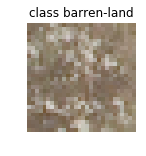

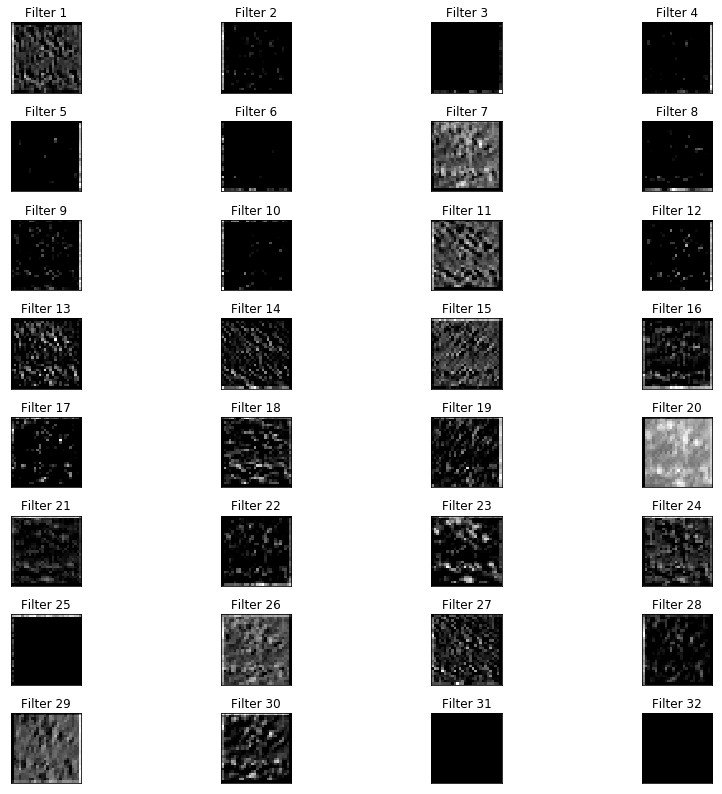

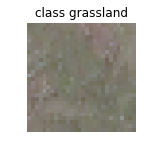

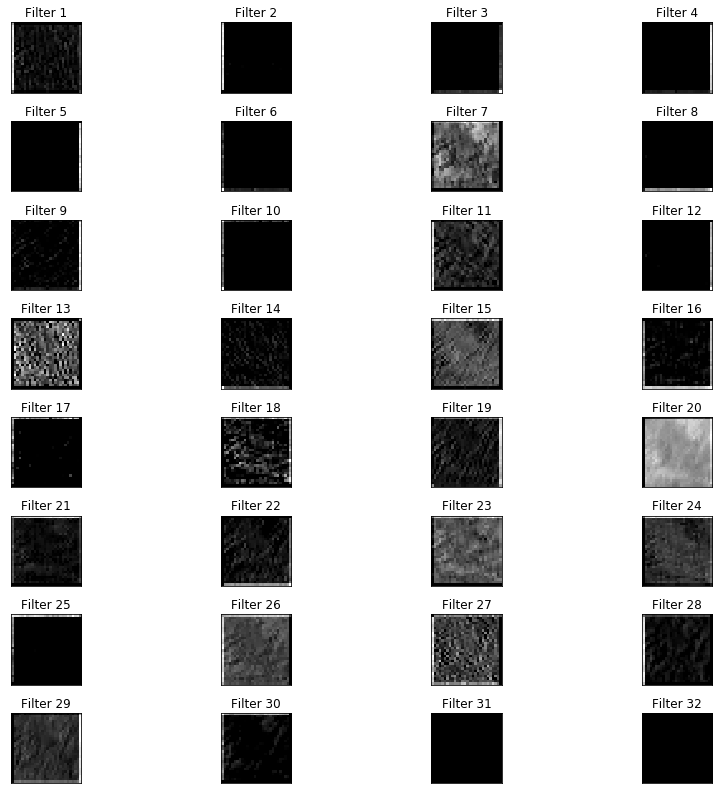

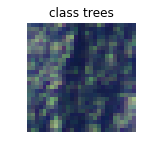

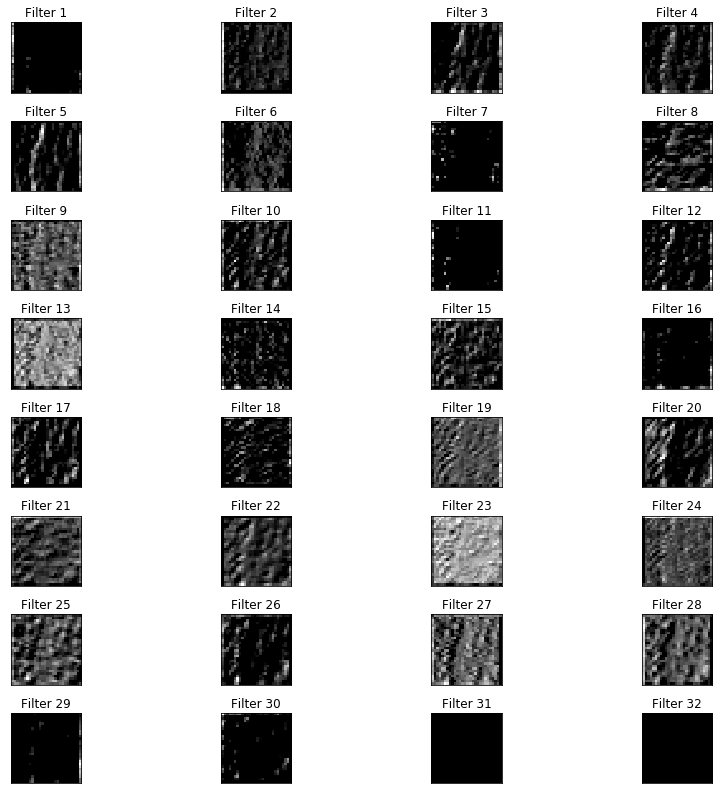

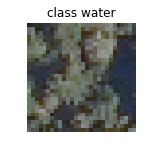

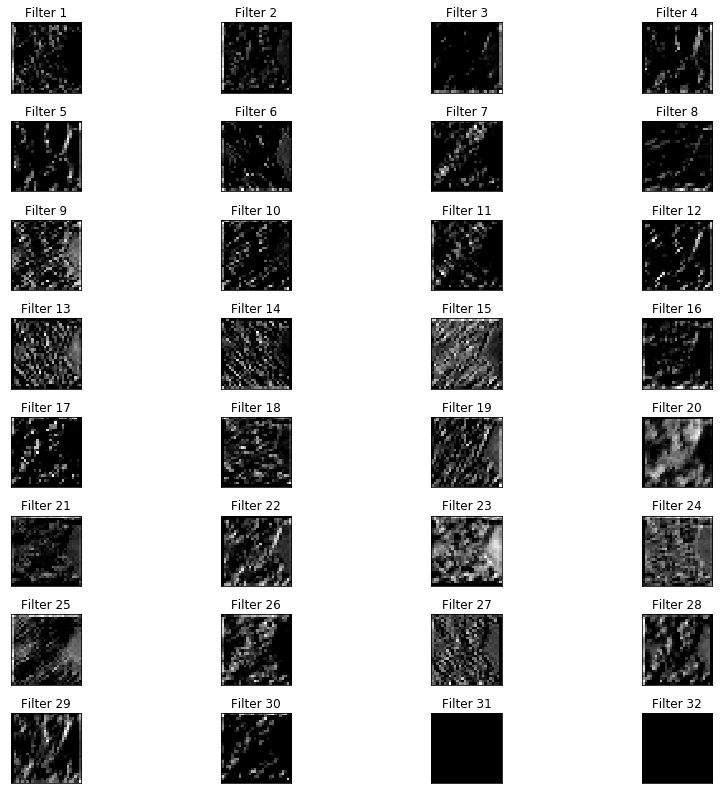

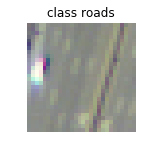

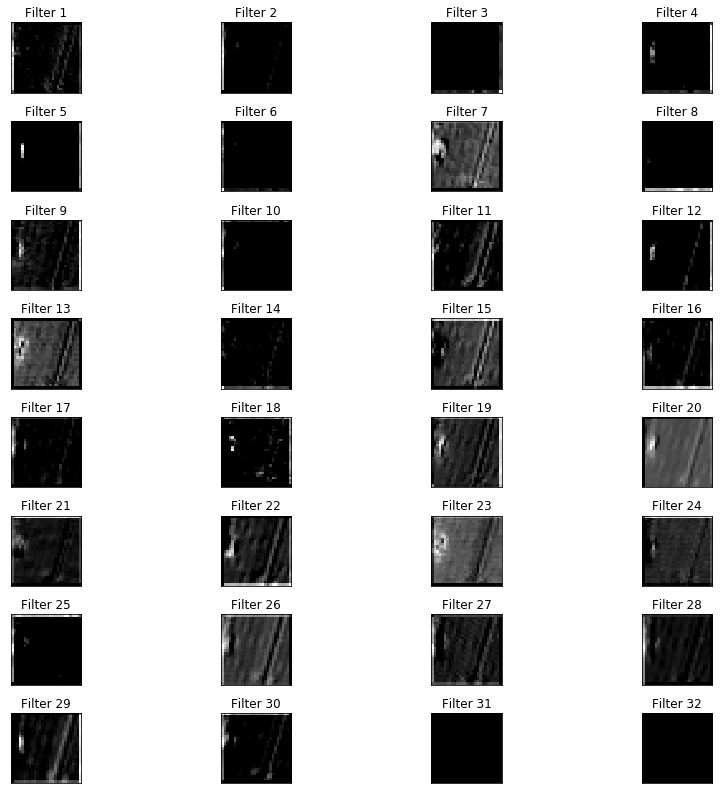

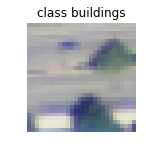

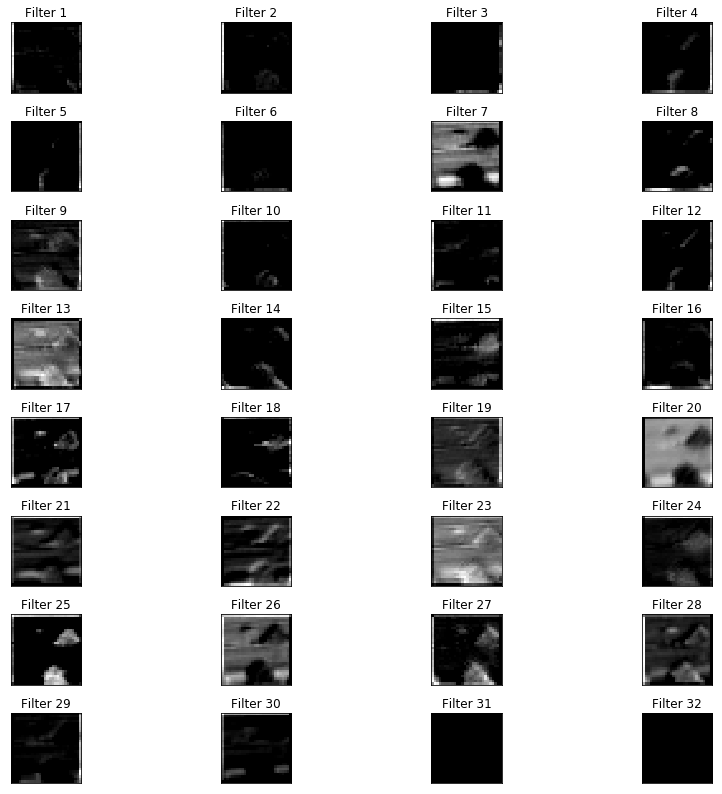

In [32]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt")
    visActivationMaps(img_vector, label_vector, conv_layer1)

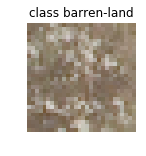

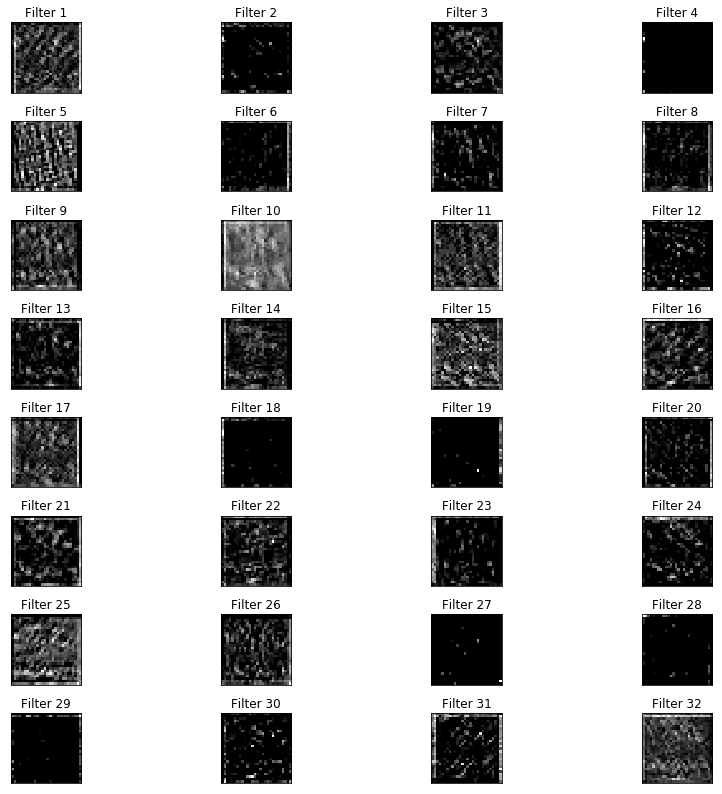

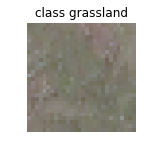

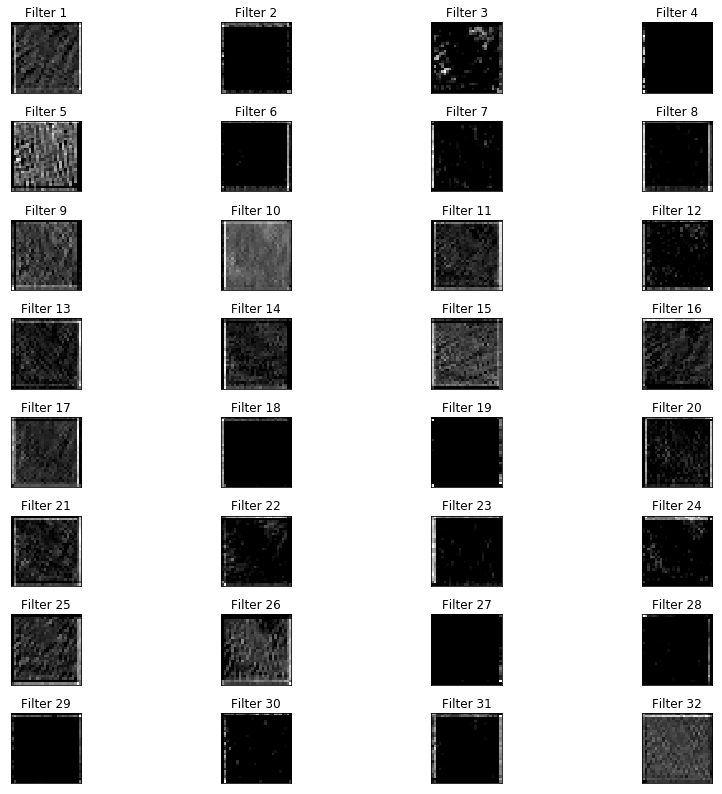

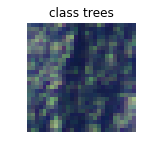

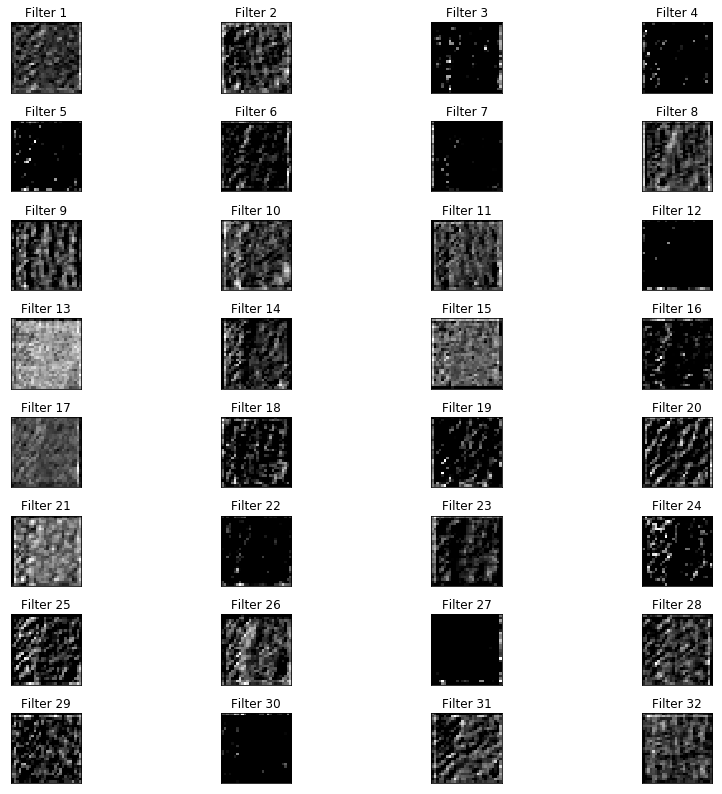

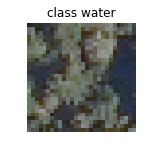

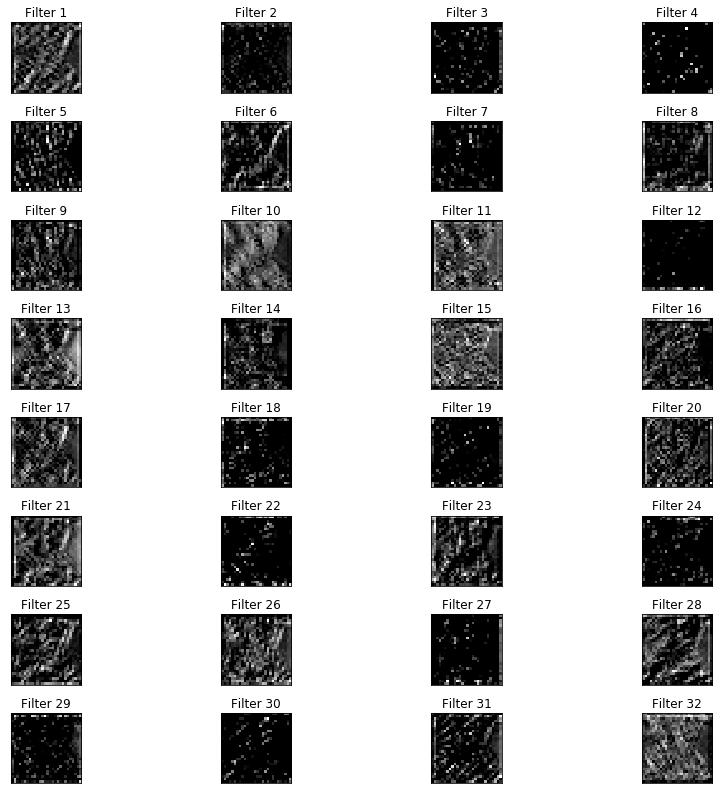

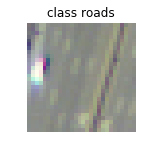

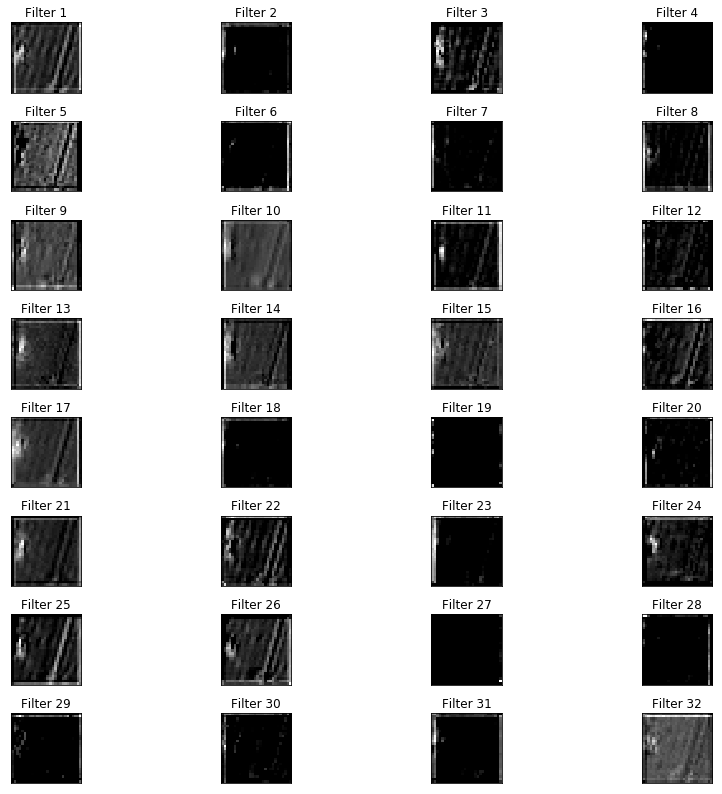

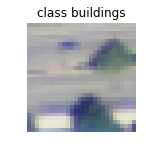

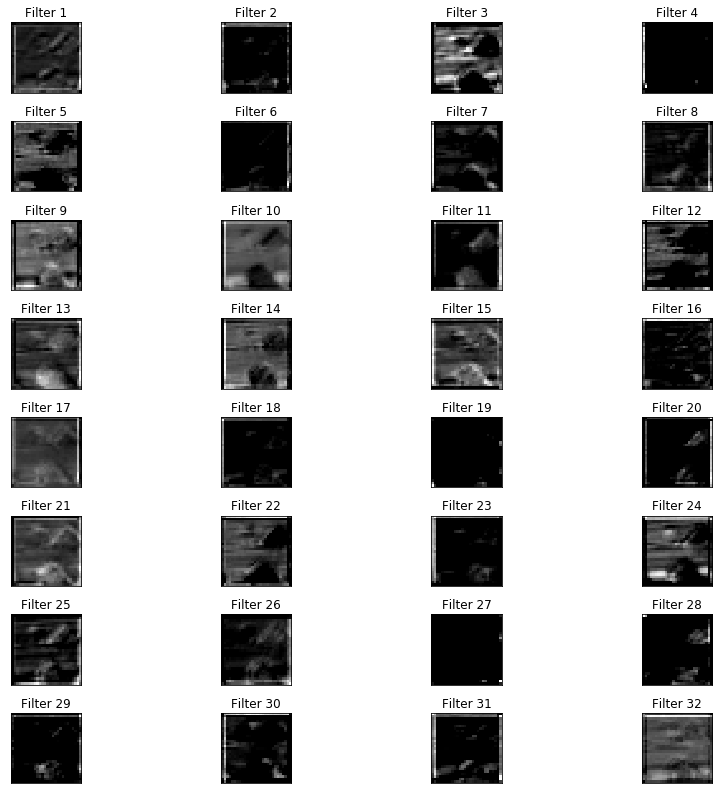

In [33]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt")
    visActivationMaps(img_vector, label_vector, conv_layer2)

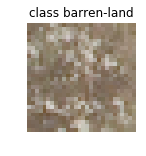

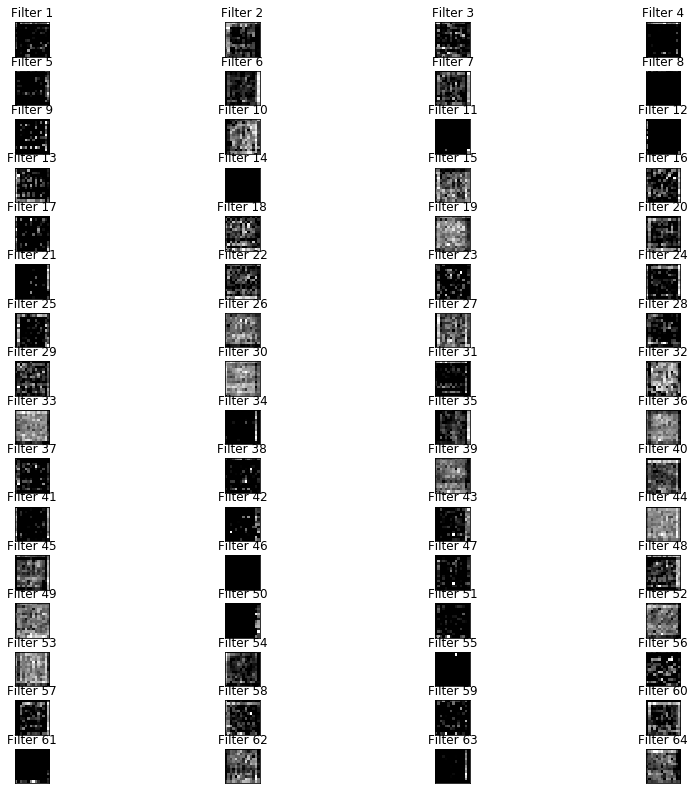

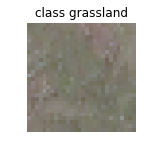

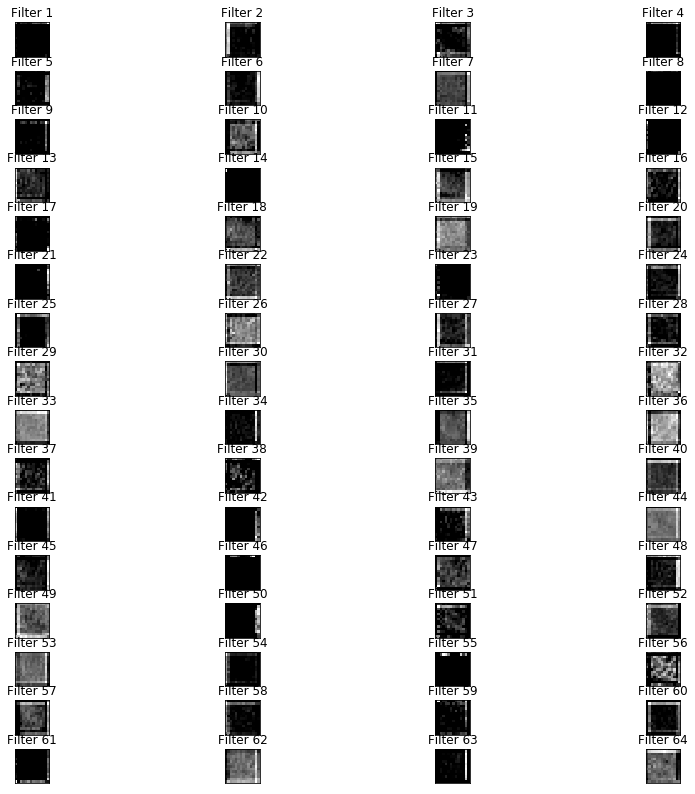

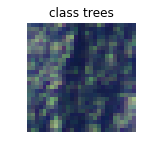

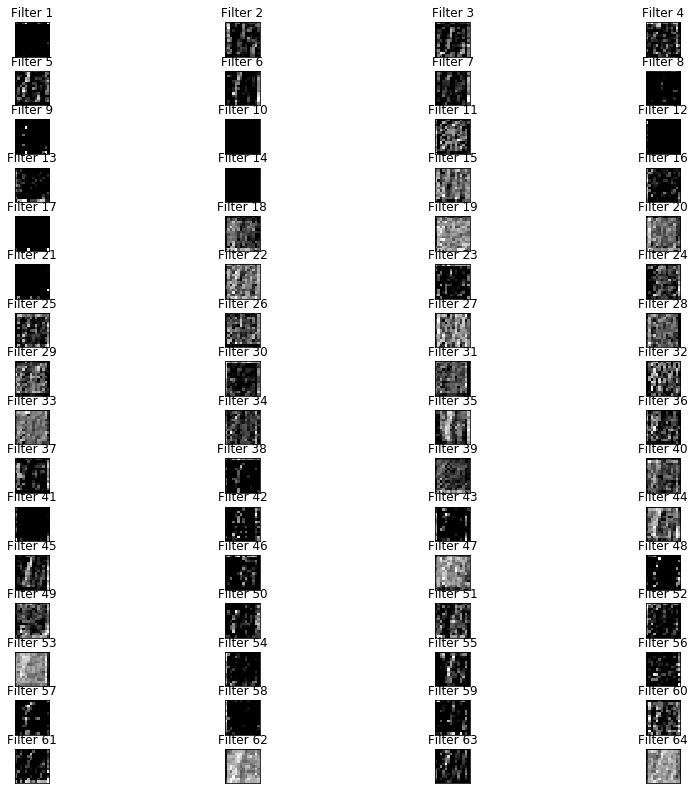

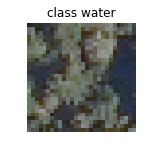

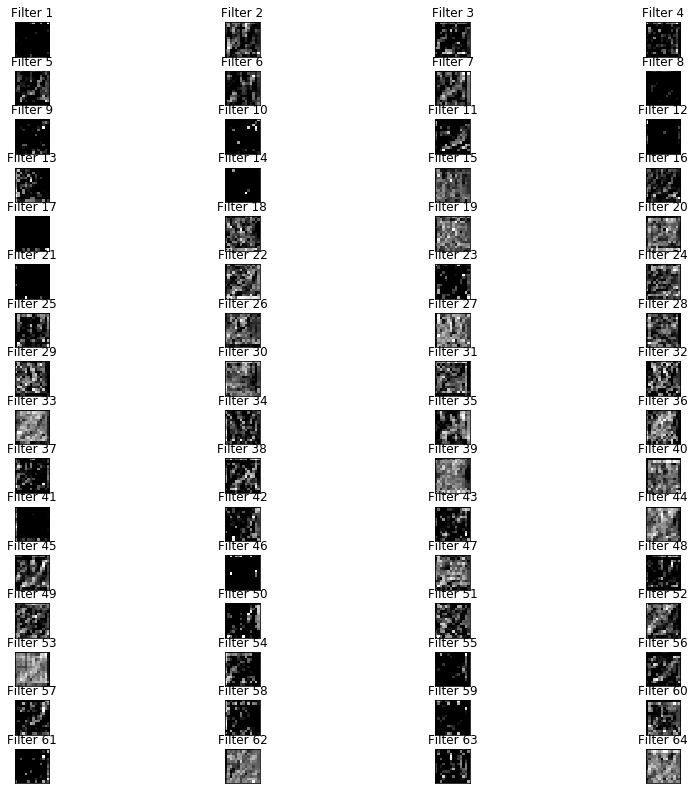

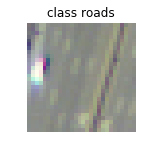

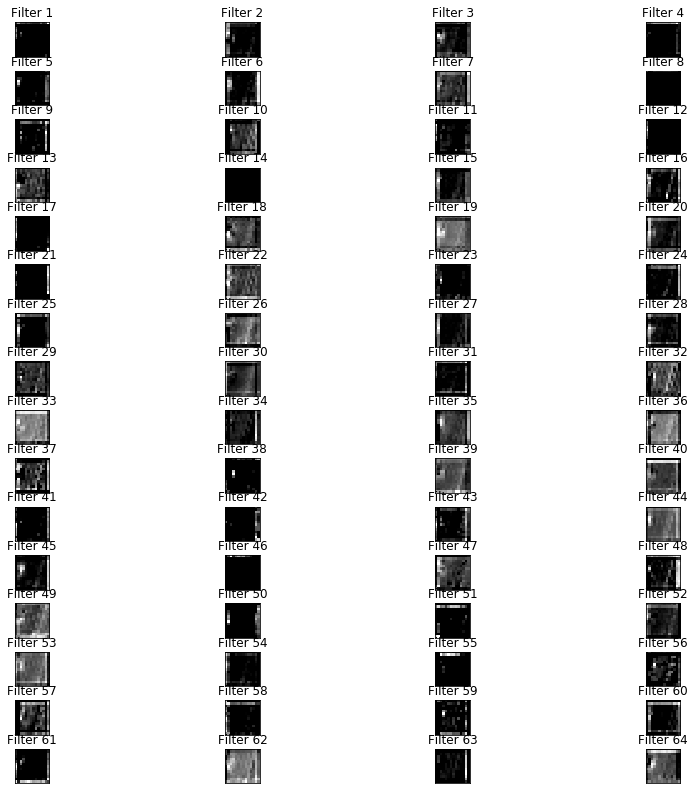

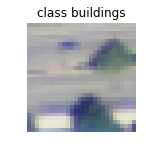

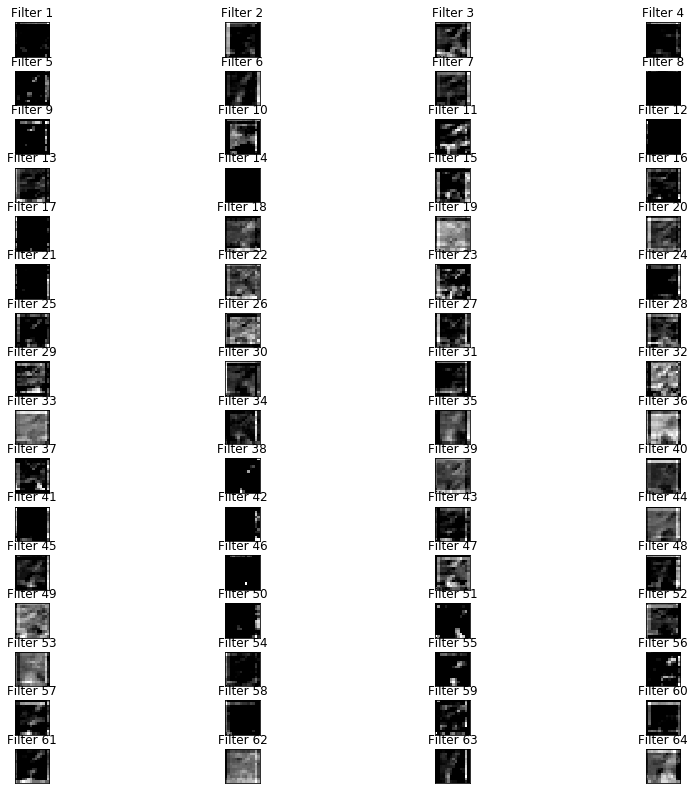

In [34]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt")
    visActivationMaps(img_vector, label_vector, conv_layer3)

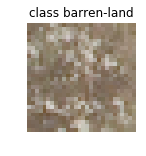

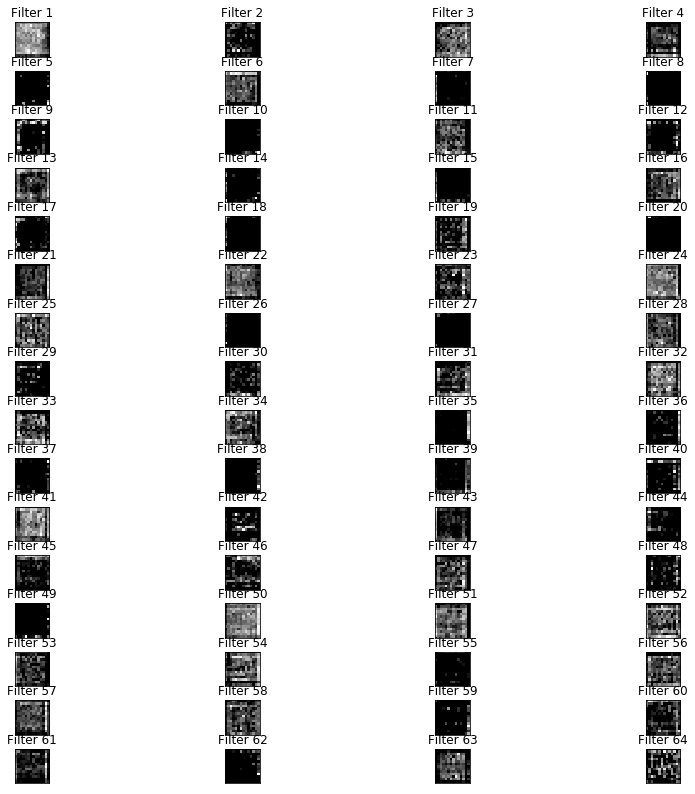

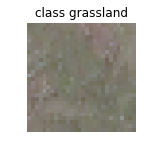

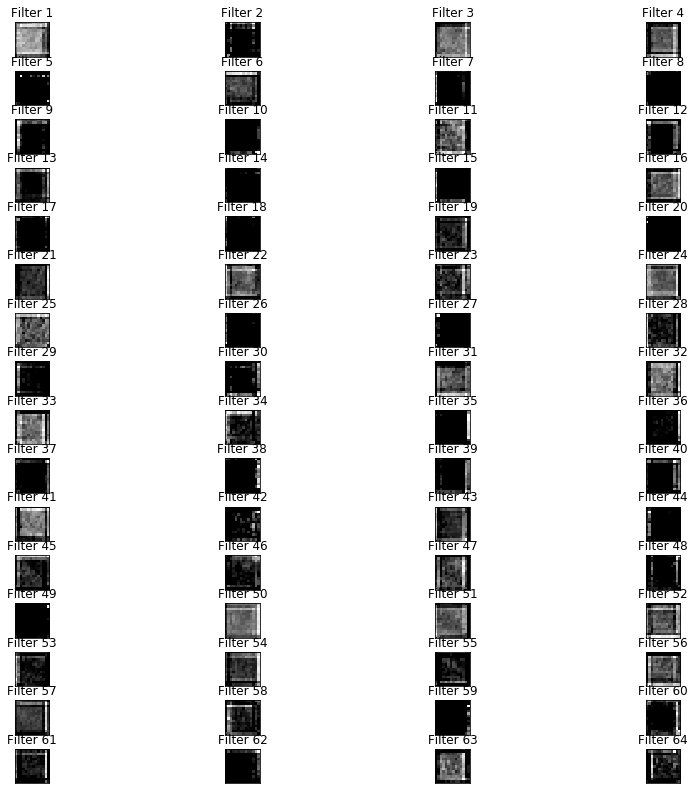

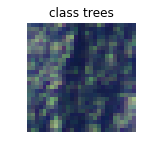

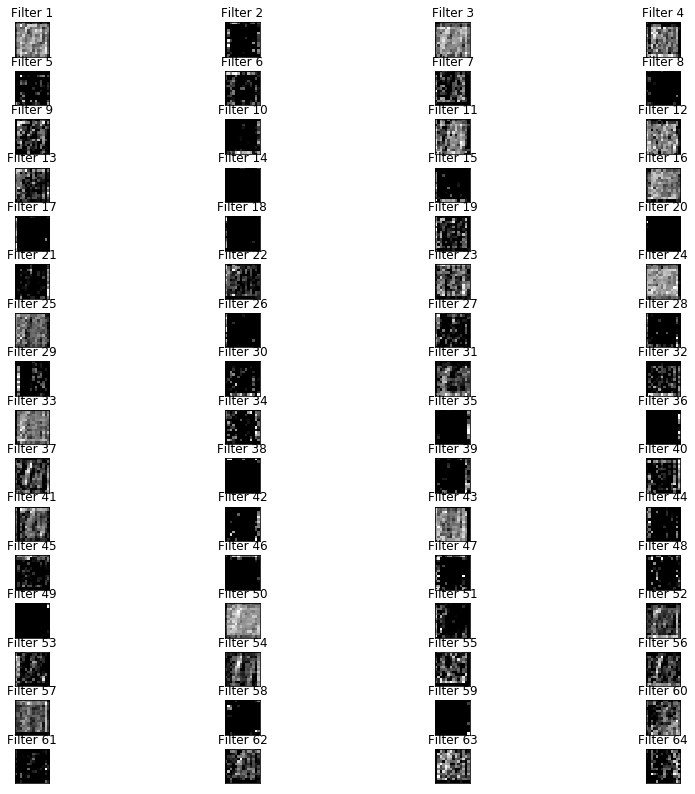

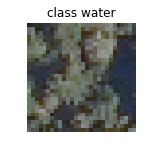

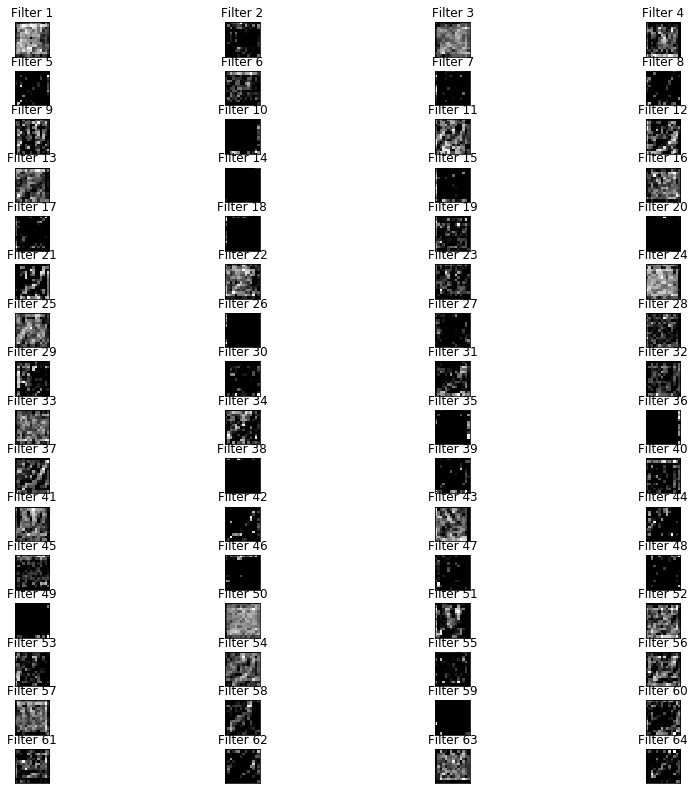

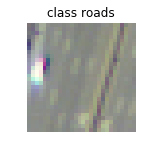

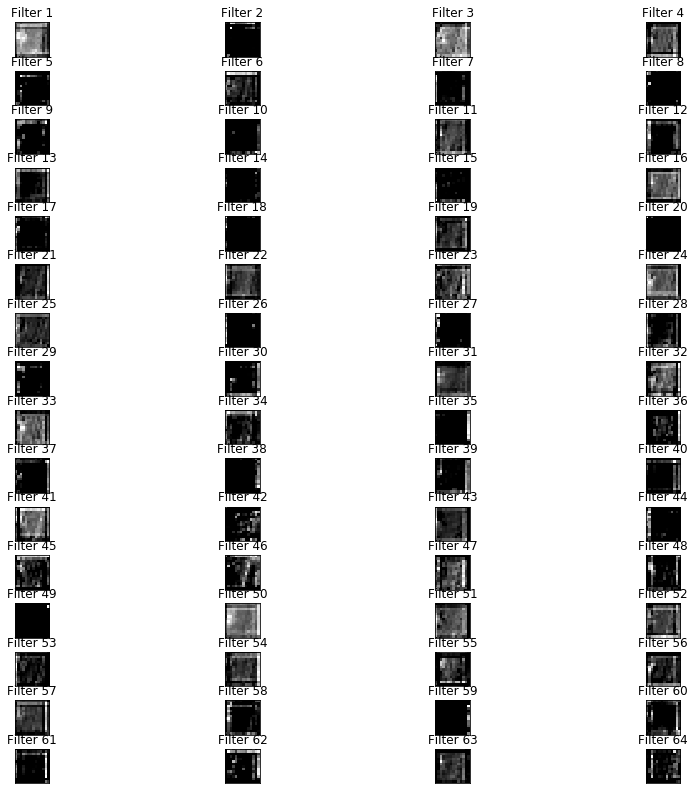

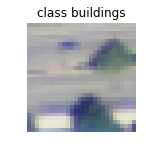

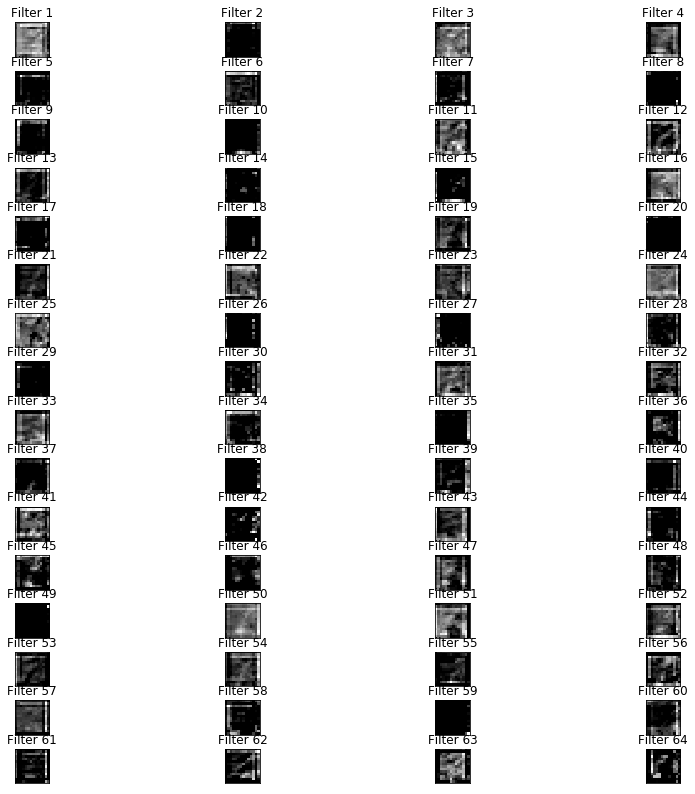

In [35]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, "./first_CNN_supervised_learning.ckpt")
    visActivationMaps(img_vector, label_vector, conv_layer4)

# Autoencoder: Unsupervised Learning

Diseñaremos un Stacked Convolutional Autoencoder (CAE), que consiste en una red convolucional de varias capaz, donde se busca encontrar una representación comprimida del output,  y a partir de esta reconstruir la imagen original. Nuestro Stacked CAE consisitirá de dos partes, un Encoder y un Decoder, con 3 capaz convolucionales con pooling  para el Encoder y 3 capaz convolucionales con unpooling para el Decoder.

## Arquitectura de nuestro modelo

(-0.5, 892.5, 381.5, -0.5)

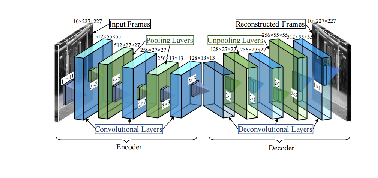

In [277]:
import matplotlib.image as mpimg
arq = mpimg.imread('/Users/mac/code/custom-cnn/arq_ae.png')
plt.imshow(arq)
plt.axis('off')

## Convolutional Stacked AutoEncoder (CAE)

In [258]:
tf.reset_default_graph()
with tf.variable_scope("CAE"):
    with tf.Session() as sess:
        n_filters = 32
        learning_rate = 0.001
        # Input and target placeholders
        inputs = tf.placeholder(tf.float32, (None, 28,28,3), name="inputs")

        # Encoder
        conv_1 = ConvLayer(inputs, n_filters, f_shape, 'conv_1') # 28x28x3 -> 28X28X32
        pool_1 = Pooling(conv_1, 'pool_1') # 28X28X32 ->14x14x32
        conv_2 = ConvLayer(pool_1, n_filters, f_shape, 'conv_2') # 14x14x32 -> 14x14x32
        pool_2 = Pooling(conv_2, 'pool_2')# 14x14x32 -> 7x7x32
        conv_3 = ConvLayer(pool_2, n_filters*2, f_shape, 'conv_3') # 7x7x32 -> 7x7x64 
        encoded = Pooling(conv_3, 'encoded') # 7x7x16 -> 4x4x16

        #Decoder
        upsample1 = tf.image.resize_images(encoded, size=(7,7), 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 4x4x16 -> 7x7x16 

        decoder_conv_1 = ConvLayer(upsample1, n_filters, f_shape, 'decoder_conv_1') # 7x7x16 -> 7x7x32

        upsample2 = tf.image.resize_images(decoder_conv_1, size=(14,14), 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 7x7x32 -> 14x14x32 

        decoder_conv_2 = ConvLayer(upsample2, n_filters, f_shape, 'decoder_conv_2') # 14x14x32  -> 14x14x32

        upsample3 = tf.image.resize_images(decoder_conv_2, size=(28,28), 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 14x14x32 -> 28x28x32 

        decoder_conv_3 = ConvLayer(upsample3, n_filters, f_shape, 'decoder_conv_3') # 28x28x32  -> 28x28x32

        #28x28x32  -> 28x28x3
        logits = tf.layers.conv2d(inputs=decoder_conv_3, filters=3, kernel_size=(3,3),
                                  padding='same', activation=None)

        # Pass logits through sigmoid to get reconstructed image
        decoded = tf.nn.sigmoid(logits)

        # Pass logits through sigmoid and calculate the cross-entropy loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=inputs, logits=logits)
        cost = tf.reduce_mean(loss)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        saver = tf.train.Saver()


## Training

In [259]:
extract1 = 0
training_filenames = [(train_images_dir+'X_train_%d.csv' % i) for i in range(1,n_training_files-extract1 +1)]
training_labels = [(train_labels_dir+'train_labels_%d.csv' % i) for i in range(1,n_training_labels-extract1 +1)]

In [260]:
#sess= tf.Session() 
#sess.run(tf.global_variables_initializer())

In [261]:
epochs = 1
training_loss =[]
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print("Starting Stacked Convolutional Autoencoder Training...")
    for i in range(epochs):
        for j in range(len(training_filenames)):
            print('file ',j+1)
            cnt=1
            for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
                batch_x, _ = process_data(image_chunk, label_chunk, img_shape)
                batch_cost, _ = sess.run([cost, opt ], feed_dict={inputs: batch_x})
                training_loss.append(batch_cost)
                print("Epoch " + str(i+1) + " Batch "+str(cnt)+": Loss= " + "{:.4f}".format(batch_cost))
                cnt+=1
        print("Processing next epoch...")
        saver.save(sess, "./convolutional_autoencoder.ckpt")
    print("  CAE training has finished.")

Starting Stacked Convolutional Autoencoder Training...
file  1
Epoch 1 Batch 1: Loss= 0.6929
Epoch 1 Batch 2: Loss= 0.6922
Epoch 1 Batch 3: Loss= 0.6910
Epoch 1 Batch 4: Loss= 0.6890
Epoch 1 Batch 5: Loss= 0.6916
Epoch 1 Batch 6: Loss= 0.6839
Epoch 1 Batch 7: Loss= 0.6844
Epoch 1 Batch 8: Loss= 0.6795
Epoch 1 Batch 9: Loss= 0.6727
Epoch 1 Batch 10: Loss= 0.6717
Epoch 1 Batch 11: Loss= 0.6644
Epoch 1 Batch 12: Loss= 0.6614
Epoch 1 Batch 13: Loss= 0.6598
Epoch 1 Batch 14: Loss= 0.6637
Epoch 1 Batch 15: Loss= 0.6648
Epoch 1 Batch 16: Loss= 0.6599
Epoch 1 Batch 17: Loss= 0.6605
Epoch 1 Batch 18: Loss= 0.6601
Epoch 1 Batch 19: Loss= 0.6555
Epoch 1 Batch 20: Loss= 0.6567
Epoch 1 Batch 21: Loss= 0.6504
Epoch 1 Batch 22: Loss= 0.6516
Epoch 1 Batch 23: Loss= 0.6464
Epoch 1 Batch 24: Loss= 0.6486
Epoch 1 Batch 25: Loss= 0.6474
Epoch 1 Batch 26: Loss= 0.6481
Epoch 1 Batch 27: Loss= 0.6450
Epoch 1 Batch 28: Loss= 0.6513
Epoch 1 Batch 29: Loss= 0.6466
Epoch 1 Batch 30: Loss= 0.6417
Epoch 1 Batch 31

Epoch 1 Batch 64: Loss= 0.6253
Epoch 1 Batch 65: Loss= 0.6256
Epoch 1 Batch 66: Loss= 0.6191
Epoch 1 Batch 67: Loss= 0.6224
Epoch 1 Batch 68: Loss= 0.6247
Epoch 1 Batch 69: Loss= 0.6323
Epoch 1 Batch 70: Loss= 0.6254
Epoch 1 Batch 71: Loss= 0.6323
Epoch 1 Batch 72: Loss= 0.6195
Epoch 1 Batch 73: Loss= 0.6291
Epoch 1 Batch 74: Loss= 0.6318
Epoch 1 Batch 75: Loss= 0.6258
Epoch 1 Batch 76: Loss= 0.6201
Epoch 1 Batch 77: Loss= 0.6218
Epoch 1 Batch 78: Loss= 0.6311
Epoch 1 Batch 79: Loss= 0.6271
Epoch 1 Batch 80: Loss= 0.6246
Epoch 1 Batch 81: Loss= 0.6221
Epoch 1 Batch 82: Loss= 0.6273
Epoch 1 Batch 83: Loss= 0.6283
Epoch 1 Batch 84: Loss= 0.6231
Epoch 1 Batch 85: Loss= 0.6276
Epoch 1 Batch 86: Loss= 0.6235
Epoch 1 Batch 87: Loss= 0.6230
Epoch 1 Batch 88: Loss= 0.6251
Epoch 1 Batch 89: Loss= 0.6331
Epoch 1 Batch 90: Loss= 0.6296
Epoch 1 Batch 91: Loss= 0.6280
Epoch 1 Batch 92: Loss= 0.6237
Epoch 1 Batch 93: Loss= 0.6235
Epoch 1 Batch 94: Loss= 0.6201
Epoch 1 Batch 95: Loss= 0.6174
Epoch 1 

Epoch 1 Batch 29: Loss= 0.6262
Epoch 1 Batch 30: Loss= 0.6219
Epoch 1 Batch 31: Loss= 0.6206
Epoch 1 Batch 32: Loss= 0.6250
Epoch 1 Batch 33: Loss= 0.6203
Epoch 1 Batch 34: Loss= 0.6306
Epoch 1 Batch 35: Loss= 0.6214
Epoch 1 Batch 36: Loss= 0.6202
Epoch 1 Batch 37: Loss= 0.6235
Epoch 1 Batch 38: Loss= 0.6200
Epoch 1 Batch 39: Loss= 0.6260
Epoch 1 Batch 40: Loss= 0.6198
Epoch 1 Batch 41: Loss= 0.6262
Epoch 1 Batch 42: Loss= 0.6235
Epoch 1 Batch 43: Loss= 0.6157
Epoch 1 Batch 44: Loss= 0.6145
Epoch 1 Batch 45: Loss= 0.6245
Epoch 1 Batch 46: Loss= 0.6261
Epoch 1 Batch 47: Loss= 0.6246
Epoch 1 Batch 48: Loss= 0.6209
Epoch 1 Batch 49: Loss= 0.6228
Epoch 1 Batch 50: Loss= 0.6292
Epoch 1 Batch 51: Loss= 0.6182
Epoch 1 Batch 52: Loss= 0.6260
Epoch 1 Batch 53: Loss= 0.6218
Epoch 1 Batch 54: Loss= 0.6224
Epoch 1 Batch 55: Loss= 0.6230
Epoch 1 Batch 56: Loss= 0.6257
Epoch 1 Batch 57: Loss= 0.6248
Epoch 1 Batch 58: Loss= 0.6213
Epoch 1 Batch 59: Loss= 0.6244
Epoch 1 Batch 60: Loss= 0.6242
Epoch 1 

Epoch 1 Batch 94: Loss= 0.6197
Epoch 1 Batch 95: Loss= 0.6198
Epoch 1 Batch 96: Loss= 0.6216
Epoch 1 Batch 97: Loss= 0.6280
Epoch 1 Batch 98: Loss= 0.6244
Epoch 1 Batch 99: Loss= 0.6209
Epoch 1 Batch 100: Loss= 0.6170
file  9
Epoch 1 Batch 1: Loss= 0.6242
Epoch 1 Batch 2: Loss= 0.6188
Epoch 1 Batch 3: Loss= 0.6323
Epoch 1 Batch 4: Loss= 0.6274
Epoch 1 Batch 5: Loss= 0.6255
Epoch 1 Batch 6: Loss= 0.6162
Epoch 1 Batch 7: Loss= 0.6194
Epoch 1 Batch 8: Loss= 0.6271
Epoch 1 Batch 9: Loss= 0.6330
Epoch 1 Batch 10: Loss= 0.6174
Epoch 1 Batch 11: Loss= 0.6301
Epoch 1 Batch 12: Loss= 0.6182
Epoch 1 Batch 13: Loss= 0.6196
Epoch 1 Batch 14: Loss= 0.6227
Epoch 1 Batch 15: Loss= 0.6269
Epoch 1 Batch 16: Loss= 0.6244
Epoch 1 Batch 17: Loss= 0.6199
Epoch 1 Batch 18: Loss= 0.6321
Epoch 1 Batch 19: Loss= 0.6200
Epoch 1 Batch 20: Loss= 0.6310
Epoch 1 Batch 21: Loss= 0.6279
Epoch 1 Batch 22: Loss= 0.6207
Epoch 1 Batch 23: Loss= 0.6283
Epoch 1 Batch 24: Loss= 0.6198
Epoch 1 Batch 25: Loss= 0.6243
Epoch 1 

## Testing

In [262]:
with tf.Session() as sess:
    saver.restore(sess, "./convolutional_autoencoder.ckpt" )
    total_test_acc = 0
    total_test_batches = 1
    for k in range(len(testing_filenames)):
        print('Testing File {} '.format(k+1))
        cnt = 1   
        for image_chunk,label_chunk in zip(pd.read_csv(test_file_path, header=None, chunksize= test_batch_size), pd.read_csv(test_label_path,header=None,chunksize=test_batch_size)):
            test_batch_x, _ = process_data(image_chunk, label_chunk, img_shape)
            decoded_val = decoded.eval(feed_dict={inputs: test_batch_x}, session=sess)
            
            testing_loss = cost.eval({inputs: test_batch_x})
    print('testing loss: ', testing_loss)

Testing File 1 
Testing File 2 
Testing File 3 
testing loss:  0.6251719


## Visualización
### reconstruccion de imagenes

(1, 28, 28, 3)


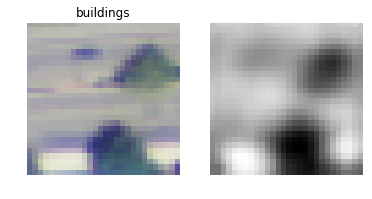

In [263]:
number = 47
sample_1 = test_images[number]
sample_label_1 = test_labels[number]
with tf.Session() as sess:
    saver.restore(sess, "./convolutional_autoencoder.ckpt")
    formatted_input = feed_format(sample_1)
    reconstructed = sess.run(decoded,feed_dict={inputs: formatted_input})
    print(reconstructed.shape)
    # of this 4-dim tensor.
    img = reconstructed[0, :, :, 0]
    # Plot image.
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(sample_1, cmap='gray')
    axarr[1].imshow(img, cmap='gray')
    f_ax=axarr.flatten()
    f_ax[0].axis('off')
    f_ax[1].axis('off')
    f_ax[0].set_title(CLASSNAMES[sample_label_1])

## Pre-training de Clasificador de Imagenes a partir de los weights del CAE

## Cambio en nuestros metodos

anteriormente estabamos ocupando los métodos provenientes de módulo tf.layers, en en cual no necesitabamos inicializar nosotros mismo los pesos y bias y asignarselos a cada una de las capas. Como queremos utilizar los pesos del stacked autoencoder para entrenar un clasificador, es necesario hacer uso del módulo tf.nn, que nos permite manualmente asignar los pesos.

In [264]:
# tf.nn.conv2d(input, filter, strides, padding="SAME", , name=None)
def conv(my_input, weights, bias, name, activation=True):
    x= tf.nn.conv2d(my_input, filter=weights, strides=[1, 1, 1, 1], padding="SAME", name=name)
    x = tf.nn.bias_add(x, bias)
    if activation == None:
        return x
    else:
        return tf.nn.relu(x)

def maxpool(layer, name):
    k=2
    return tf.nn.max_pool(layer, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME', name=name)

def upsample(maxpool_layer, size):
    return tf.image.resize_images(maxpool_layer, size=(size, size), 
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def OutputLayer(dense_layer, name):
    return tf.layers.dense(inputs=dense_layer, units=n_classes, name=name)

In [265]:
with tf.Session() as sess:
    saver.restore(sess, "./convolutional_autoencoder.ckpt")
    weights_1= tf.get_collection(tf.GraphKeys.VARIABLES, 'CAE/conv_1/kernel')[0]
    weights_2= tf.get_collection(tf.GraphKeys.VARIABLES, 'CAE/conv_2/kernel')[0]
    weights_3= tf.get_collection(tf.GraphKeys.VARIABLES, 'CAE/conv_3/kernel')[0]
    #variables= tf.get_collection(tf.GraphKeys.VARIABLES)
    #print(variables)
    with tf.variable_scope('pre-trained', reuse=tf.AUTO_REUSE):
        learning_rate = 0.001
        n_filters = 32
        #placehoder
        inputs = tf.placeholder(tf.float32, (None, 28,28,3), name="my_input")
        labels = tf.placeholder(tf.float32, (None, n_classes),name ='my_labels')
        drop_prob = tf.placeholder("float")
        #weights and biases
        #w1 = tf.get_variable("w1", shape=[3, 3, 3, n_filters])
        w1 = weights_1
        b1 = tf.get_variable("b1", shape=[n_filters], initializer=tf.constant_initializer(0.0))

        #w2 = tf.get_variable("w2", shape=[3, 3, n_filters, n_filters])
        w2 = weights_2

        b2 = tf.get_variable("b2", shape=[n_filters], initializer=tf.constant_initializer(0.0))

        #w3 = tf.get_variable("w3", shape=[3, 3, n_filters, 2*n_filters])
        w3 = weights_3
        b3 = tf.get_variable("b3", shape=[2*n_filters], initializer=tf.constant_initializer(0.0)) 

        w4 = tf.get_variable("w4", shape=[3, 3, 2*n_filters, 2*n_filters])
        b4 = tf.get_variable("b4", shape=[2*n_filters], initializer=tf.constant_initializer(0.0)) 


        #model
        #28x28x1 ->28x28x32 (conv1)
        conv1 = conv(inputs, w1, b1, name='conv1')
        #28x28x32 -> 28x28x32 (conv2)
        conv2 = conv(conv1, w2, b2, name='conv2')
        # 28x28x32 -> 14x14x32 (maxpool1)
        pool1 = maxpool(conv2, name='pool1')
        #14x14x32 -> 14x14x64(conv3)
        conv3 = conv(pool1, w3, b3, name='conv3')    
        #14x14x64 -> 14x14x64 (conv4)
        conv4 = conv(conv3, w4, b4, name='conv4') 
        #14x14x64 -> 7x7x64 (maxpool2)
        pool2 = maxpool(conv4, name='pool2')
        #(flatten)
        flat = tf.layers.flatten(inputs=pool2, name='flatten')
        #dense
        dense = tf.layers.dense(inputs=flat, units=1024, activation= tf.nn.relu, name='dense_2')       
        #dropout
        dropout = tf.layers.dropout(inputs= dense, rate=drop_prob, name='dropout')    
        #prediciton (OutputLayer Wrapper)
        #pred = tf.layers.dense(inputs=dropout, units=classes, name='predict', activation=None)
        prediction = OutputLayer(dropout, 'predict')    
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        saver = tf.train.Saver()

## Training

In [266]:
train_loss = []
train_accuracy = []
print("Starting Training of pre-trained CNN...")
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(epochs):
        for j in range(len(training_filenames)):
            print("Training File " + str(j) + ": ")
            cnt = 1
            for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
                batch_x, batch_y = process_data(image_chunk, label_chunk, img_shape)

                # Run optimization op (backprop).
                opt = sess.run(optimizer, feed_dict={inputs: batch_x, labels: batch_y, drop_prob: 0.5})
                loss, acc = sess.run([cost, accuracy], feed_dict={inputs: batch_x, labels: batch_y, drop_prob: 0.5})

                if(cnt%10==0):
                    train_loss.append(loss)
                    train_accuracy.append(acc)
                    print("Batch " + "{:2d}".format(cnt)  + ": Loss= " + \
                                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                                  "{:.4f}".format(acc))
                    print("Processing next 10 training Batches...")
                cnt+=1

        print("Epoch " + str(i) + ": Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.4f}".format(acc))
        print("Processing next epoch...")
    saver.save(sess, "./pre-trained_CNN.ckpt")
    print("Training has finished.")

Starting Training of pre-trained CNN...
Training File 0: 
Batch 10: Loss= 1.1174, Training Accuracy= 0.5926
Processing next 10 training Batches...
Batch 20: Loss= 0.5983, Training Accuracy= 0.7654
Processing next 10 training Batches...
Batch 30: Loss= 0.4185, Training Accuracy= 0.8519
Processing next 10 training Batches...
Batch 40: Loss= 0.2934, Training Accuracy= 0.8827
Processing next 10 training Batches...
Batch 50: Loss= 0.3189, Training Accuracy= 0.8364
Processing next 10 training Batches...
Batch 60: Loss= 0.1901, Training Accuracy= 0.9321
Processing next 10 training Batches...
Batch 70: Loss= 0.1745, Training Accuracy= 0.9506
Processing next 10 training Batches...
Batch 80: Loss= 0.1486, Training Accuracy= 0.9506
Processing next 10 training Batches...
Batch 90: Loss= 0.1522, Training Accuracy= 0.9444
Processing next 10 training Batches...
Batch 100: Loss= 0.1925, Training Accuracy= 0.8951
Processing next 10 training Batches...
Training File 1: 
Batch 10: Loss= 0.1856, Training 

Batch 10: Loss= 0.1186, Training Accuracy= 0.9599
Processing next 10 training Batches...
Batch 20: Loss= 0.1075, Training Accuracy= 0.9568
Processing next 10 training Batches...
Batch 30: Loss= 0.0667, Training Accuracy= 0.9784
Processing next 10 training Batches...
Batch 40: Loss= 0.0550, Training Accuracy= 0.9846
Processing next 10 training Batches...
Batch 50: Loss= 0.0486, Training Accuracy= 0.9846
Processing next 10 training Batches...
Batch 60: Loss= 0.0564, Training Accuracy= 0.9846
Processing next 10 training Batches...
Batch 70: Loss= 0.0412, Training Accuracy= 0.9938
Processing next 10 training Batches...
Batch 80: Loss= 0.0746, Training Accuracy= 0.9784
Processing next 10 training Batches...
Batch 90: Loss= 0.0852, Training Accuracy= 0.9537
Processing next 10 training Batches...
Batch 100: Loss= 0.0305, Training Accuracy= 0.9877
Processing next 10 training Batches...
Epoch 0: Loss= 0.0305, Training Accuracy= 0.9877
Processing next epoch...
Training has finished.


## Testing

In [267]:
with tf.Session() as sess:
    saver.restore(sess, "./pre-trained_CNN.ckpt" )
    print("Starting Testing...")
    total_test_acc = 0
    total_test_batches = 1
    for k in range(len(testing_filenames)):
        print('Testing File {} '.format(k+1))   
        for image_chunk,label_chunk in zip(pd.read_csv(test_file_path, header=None, chunksize= test_batch_size), pd.read_csv(test_label_path,header=None,chunksize=test_batch_size)):
            test_batch_x, test_batch_y = process_data(image_chunk, label_chunk, img_shape)

            test_acc, test_loss = sess.run([accuracy,cost], feed_dict={inputs: test_batch_x, labels : test_batch_y, drop_prob: 1.0})
            total_test_acc += test_acc
            total_test_batches += 1

    avg_test_acc = total_test_acc/total_test_batches
    print("Testing Accuracy:","{:.4f}".format(avg_test_acc))

Starting Testing...
Testing File 1 
Testing File 2 
Testing File 3 
Testing Accuracy: 0.9726


In [269]:
def process_demo_data(train_path, label_path, img_shape, n_rows):
    # Pre-processing data. Returns numpy arrays
    img_df = pd.read_csv(train_path, nrows=n_rows, header=None) 
    labels_df = pd.read_csv(label_path, nrows=n_rows, header=None)
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]
    np_x = np_x/255

    y = labels_df.values.astype(np.uint8)

    return np_x, y

In [270]:
for i in range(50):
    number = i
    print('test image Nº {}'.format(i))
    test_images_2, test_labels_2 = process_demo_data(test_file_path, test_label_path, img_shape, 50)
    test_labels_2 = test_labels_2.reshape(-1, test_labels_2.shape[1])
    sample_1 = test_images_2[number]
    sample_label_1 = test_labels_2[number:number+1]

    with tf.Session() as sess:
        saver.restore(sess, "./pre-trained_CNN.ckpt" )
        formatted_input = feed_format(sample_1) 
        image_class = sess.run(prediction, feed_dict={inputs: formatted_input, labels: sample_label_1, drop_prob : 1.0})
        pred_class = (tf.argmax(image_class,1).eval())
        print('predicted class: ({}) '.format(pred_class[0]) + CLASSNAMES[pred_class[0]])
        true_class =np.argmax(sample_label_1)
        print('true class:      ({}) '.format(true_class) + CLASSNAMES[true_class])
        print('\n')

test image Nº 0
predicted class: (1) barren-land
true class:      (1) barren-land


test image Nº 1
predicted class: (3) grassland
true class:      (3) grassland


test image Nº 2
predicted class: (1) barren-land
true class:      (1) barren-land


test image Nº 3
predicted class: (5) trees
true class:      (5) trees


test image Nº 4
predicted class: (1) barren-land
true class:      (1) barren-land


test image Nº 5
predicted class: (2) water
true class:      (2) water


test image Nº 6
predicted class: (2) water
true class:      (2) water


test image Nº 7
predicted class: (5) trees
true class:      (5) trees


test image Nº 8
predicted class: (1) barren-land
true class:      (1) barren-land


test image Nº 9
predicted class: (5) trees
true class:      (5) trees


test image Nº 10
predicted class: (5) trees
true class:      (5) trees


test image Nº 11
predicted class: (1) barren-land
true class:      (1) barren-land


test image Nº 12
predicted class: (5) trees
true class:      (5) t

predicted class: (3) grassland
true class: (1)  barren-land


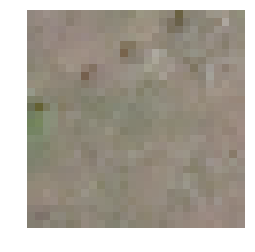

In [285]:
number = 27
test_images_2, test_labels_2 = process_demo_data(test_file_path, test_label_path, img_shape, 50)
test_labels_2 = test_labels_2.reshape(-1, test_labels_2.shape[1])
sample_1 = test_images_2[number]
sample_label_1 = test_labels_2[number:number+1]

with tf.Session() as sess:
    saver.restore(sess, "./pre-trained_CNN.ckpt" )
    
    formatted_input = feed_format(sample_1) 
    image_class = sess.run(prediction, feed_dict={inputs: formatted_input, labels: sample_label_1, drop_prob : 1.0})
    pred_class = (tf.argmax(image_class,1).eval())
    print('predicted class: ({}) '.format(pred_class[0]) + CLASSNAMES[pred_class[0]])
    
    true_class =np.argmax(sample_label_1)
    print('true class: ({})  '.format(true_class) + CLASSNAMES[true_class])
    plt.imshow(sample_1, cmap='gray')
    plt.axis('off')    
    
    

## Visualización del cambio de la función de costos y la precisión 

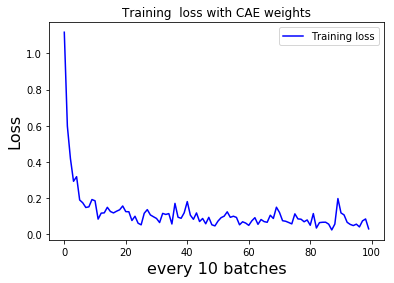

In [278]:
fig1 = plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.title('Training  loss with CAE weights')
plt.xlabel('every 10 batches',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
fig1.savefig('pre-trained-CNN-loss.png')
plt.show()

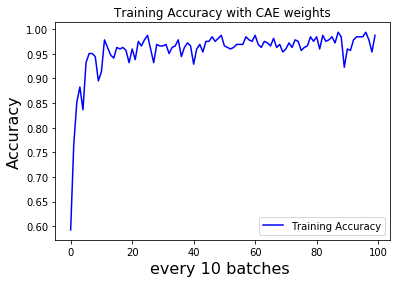

In [279]:
fig2 = plt.figure()
plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy with CAE weights')
plt.xlabel('every 10 batches ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
fig2.savefig('pre-trained-CNN-acc.png')
plt.show()